# How to use prior knowledge in GroupDirectLiNGAM

## Import and settings
In this example, we need to import `numpy`, `pandas`, and `graphviz` in addition to `lingam`.

In [4]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_prior_knowledge, make_dot

import warnings
warnings.filterwarnings('ignore')

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.26.4', '2.2.3', '0.20.3', '1.11.0']


## Utility function
We define a utility function to draw the directed acyclic graph.

In [11]:
def make_prior_knowledge_graph(prior_knowledge_matrix):
    d = graphviz.Digraph(engine='dot')
    
    labels = [f'group{i}' for i in range(prior_knowledge_matrix.shape[0])]
    for label in labels:
        d.node(label, label)

    dirs = np.where(prior_knowledge_matrix > 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        d.edge(labels[from_], labels[to])

    dirs = np.where(prior_knowledge_matrix < 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        if to != from_:
            d.edge(labels[from_], labels[to], style='dashed')
    return d

## Test data
First, we generate a causal structure with 6 variables. Then we create a dataset with 6 variables from x0 to x5.

These variables are grouped as follows:
- Group 1: x0, x1
- Group 2: x2
- Group 3: x3, x4
- Group 4: x5

In [6]:
np.random.seed(0)

n_samples = 1000
x0 = np.random.uniform(size=n_samples)
x1 = 2.0 * x0 + np.random.uniform(size=n_samples)
x2 = 0.5 * x1 + np.random.uniform(-1, 1, size=n_samples)
x3 = 0.3 * x1 + 0.7 * x2 + np.random.uniform(-2, 2, size=n_samples)
x4 = 1.5 * x0 + 0.8 * x3 + np.random.uniform(-2, 2, size=n_samples)
x5 = -0.6 * x3 - 0.5 * x4 + np.random.uniform(-3, 3, size=n_samples)

X = pd.DataFrame(np.array([x0, x1, x2, x3, x4, x5]).T ,columns=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])
groups = [[0, 1], [2], [3, 4], [5]]

X.head()

,x0,x1,x2,x3,x4,x5
0,0.548814,1.690507,1.468291,1.190806,0.946433,-1.987018
1,0.715189,1.440442,0.672389,1.421278,2.475880,-3.304962
2,0.602763,1.681353,0.886988,2.239635,1.245511,-4.554939
3,0.544883,1.798537,0.400310,2.226009,1.996981,-3.218930
4,0.423655,0.891285,0.655729,1.992046,0.441985,-3.023044


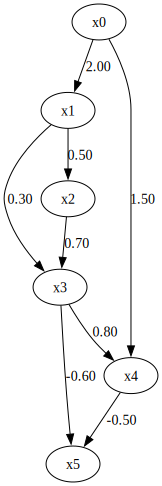

In [7]:
m = np.array([
    [  0,   0,   0,   0,   0, 0],
    [2.0,   0,   0,   0,   0, 0],
    [  0, 0.5,   0,   0,   0, 0],
    [  0, 0.3, 0.7,   0,   0, 0],
    [1.5,   0,   0, 0.8,   0, 0],
    [  0,   0,   0,-0.6,-0.5, 0]])

dot = make_dot(m, labels=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])

# Save pdf
dot.render('dag')

# Save png
dot.format = 'png'
dot.render('dag')

dot

## Make Prior Knowledge Matrix
We create prior knowledge so that group0 and group3 are sink groups.

The elements of prior knowledge matrix are defined as follows:
* ``0`` : `x_i` does not have a directed path to `x_j`
* ``1`` : `x_i` has a directed path to `x_j`
* ``-1`` : No prior knowledge is available to know if either of the two cases above (0 or 1) is true.

In [9]:
n_groups = len(groups)
prior_knowledge = make_prior_knowledge(
    n_variables=n_groups,
    sink_variables=[0, 3]
)
print(prior_knowledge)

[[-1 -1 -1  0]
 [ 0 -1 -1  0]
 [ 0 -1 -1  0]
 [ 0 -1 -1 -1]]


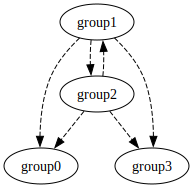

In [14]:
# Draw a graph of prior knowledge
make_prior_knowledge_graph(prior_knowledge)

## Causal Discovery
To run causal discovery using prior knowledge, we create a `GroupDirectLiNGAM` object with the prior knowledge matrix.

In [15]:
model = lingam.GroupDirectLiNGAM(prior_knowledge=prior_knowledge)
model.fit(X, groups)
print(model.causal_order_)
print(model.adjacency_matrix_)

[1, 2, 0, 3]
[[ 0.     0.     0.155 -0.044  0.075  0.   ]
 [ 0.     0.     0.417 -0.07   0.139  0.   ]
 [ 0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.885  0.     0.     0.   ]
 [ 0.     0.     0.922  0.     0.     0.   ]
 [ 0.     0.     0.    -0.622 -0.487  0.   ]]


We can see that group0 (x0 and x1) and group3 (x5) are output as sink groups, as specified in the prior knowledge.

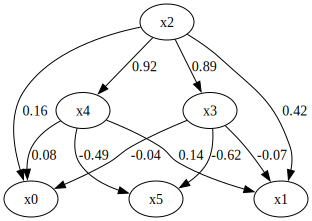

In [17]:
make_dot(model.adjacency_matrix_)

Next, let's specify the prior knowledge so that group2 (x3, x4) is an exogenous variable.

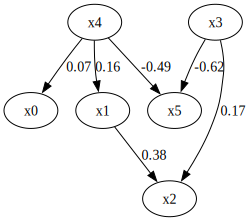

In [18]:
n_groups = len(groups)
prior_knowledge = make_prior_knowledge(
    n_variables=n_groups,
    exogenous_variables=[2],
)

model = lingam.GroupDirectLiNGAM(prior_knowledge=prior_knowledge)
model.fit(X, groups)

make_dot(model.adjacency_matrix_)